# Non stationary kernels in GP
> A programming introduction to Bayesian Linear Regression.

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [36]:
k = RBF()

x = np.linspace(-1, 1, 20).reshape(-1, 1)

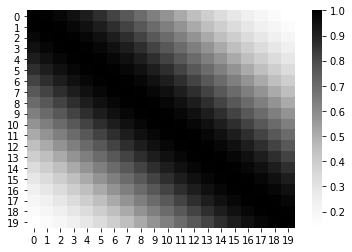

In [37]:
sns.heatmap(k(x),cmap='Greys')

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [62]:
gpr = GaussianProcessRegressor(kernel=dot_kernel+k)

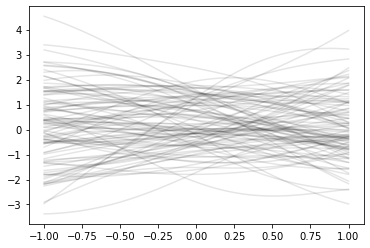

In [63]:
plt.plot(x, gpr.sample_y(x, n_samples=100),color='k',alpha=0.1);

In [55]:
from sklearn.gaussian_process.kernels import DotProduct
dot_kernel = DotProduct(sigma_0=0.)

In [80]:
x = np.linspace(-5, 5, 25).reshape(-1, 1)

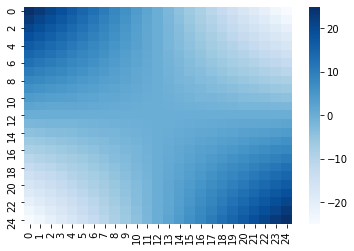

In [82]:
sns.heatmap(dot_kernel(x),cmap='Blues')

/usr/local/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


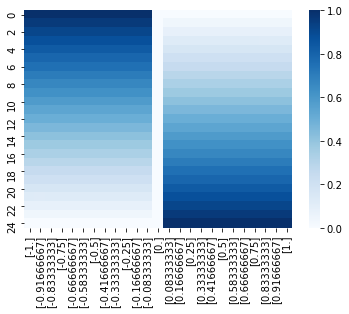

In [79]:
from sklearn.preprocessing import MinMaxScaler
m = MinMaxScaler()
sns.heatmap(m.fit_transform(dot_kernel(x)),cmap='Blues',xticklabels=x)

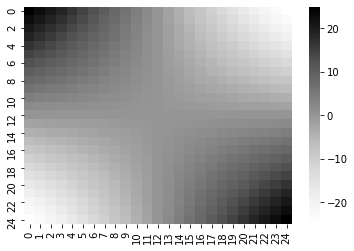

In [65]:
sns.heatmap(dot_kernel(x),cmap='Greys')

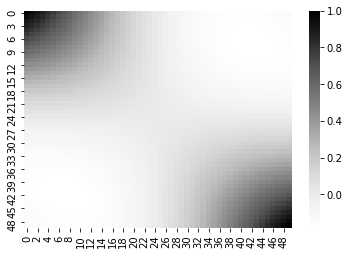

In [59]:
sns.heatmap((dot_kernel*k)(x),cmap='Greys')

In [3]:
y = 5*x + 4 
noise = (np.abs(x.flatten())*np.random.randn(len(x))).reshape(-1,1)
y = y + noise


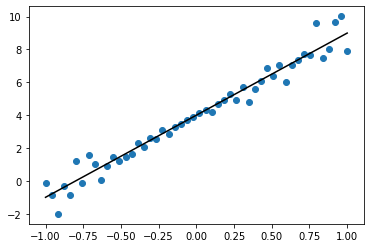

In [4]:
plt.scatter(x, y)
plt.plot(x, 5*x + 4, 'k')

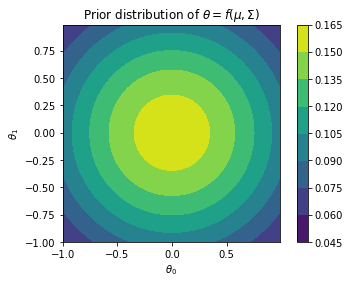

In [5]:
from scipy.stats import multivariate_normal
from matplotlib import cm
cov = np.array([[ 1 , 0], [0,  1]])
var = multivariate_normal(mean=[0,0], cov=cov)
x_grid, y_grid = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x_grid, y_grid))
z = var.pdf(pos)
plt.contourf(x_grid, y_grid, z)
plt.gca().set_aspect('equal')
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.title(r"Prior distribution of $\theta = f(\mu, \Sigma)$")
plt.colorbar()

$$
\prod_{i=1}^{n} \frac{1}{\sqrt{2 \pi \sigma^{2}}} e^{-\frac{(y_{i}-\hat{y}_{i})^{2}}{2 \sigma^{2}}}
$$

### Sample from prior

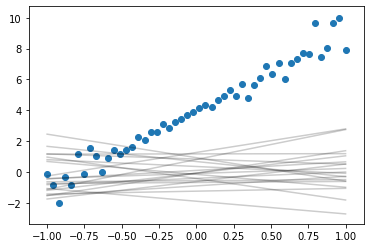

In [6]:
n_samples = 20
for n in range(n_samples):
    theta_0_s, theta_1_s = var.rvs()
    plt.plot(x, theta_1_s*x + theta_0_s, color='k',alpha=0.2)
plt.scatter(x, y)


### Likelihood of theta

In [7]:
def likelihood(theta_0, theta_1, x, y, sigma):
    s = 0
    x_plus_1 = np.hstack((np.ones_like(x), x))

    for i in range(len(x)):
        y_i_hat = x_plus_1[i, :]@np.array([theta_0, theta_1])
        s += (y[i,:]-y_i_hat)**2
    
    
    return np.exp(-s/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)

In [8]:
likelihood(-1, 1, x, y, 4)

array([1.00683395e-22])

In [9]:
x_grid_2, y_grid_2 = np.mgrid[0:8:.1, 0:8:.1]

li = np.zeros_like(x_grid_2)
for i in range(x_grid_2.shape[0]):
    for j in range(x_grid_2.shape[1]):
        li[i, j] = likelihood(x_grid_2[i, j], y_grid_2[i, j], x, y, 4)
        

Text(0.5, 1.0, 'Likelihood as a function of ($\\theta_0, \\theta_1$)')

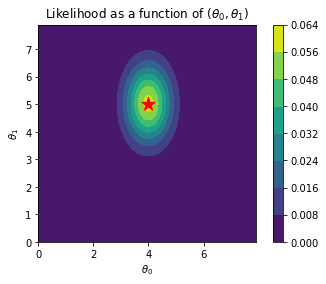

In [10]:
plt.contourf(x_grid_2, y_grid_2, li)
plt.gca().set_aspect('equal')
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.colorbar()
plt.scatter(4, 5, s=200, marker='*', color='r')
plt.title(r"Likelihood as a function of ($\theta_0, \theta_1$)")

### Likelihood of $\sigma^2$

In [11]:
x_plus_1 = np.hstack((np.ones_like(x), x))

theta_mle = np.linalg.inv(x_plus_1.T@x_plus_1)@(x_plus_1.T@y)
sigma_2_mle = np.linalg.norm(y - x_plus_1@theta_mle)**2
sigma_mle = np.sqrt(sigma_2_mle)
sigma_mle

4.128685902124939

### Posterior

$$
\begin{aligned}
p(\boldsymbol{\theta} | \mathcal{X}, \mathcal{Y}) &=\mathcal{N}\left(\boldsymbol{\theta} | \boldsymbol{m}_{N}, \boldsymbol{S}_{N}\right) \\
\boldsymbol{S}_{N} &=\left(\boldsymbol{S}_{0}^{-1}+\sigma^{-2} \boldsymbol{\Phi}^{\top} \boldsymbol{\Phi}\right)^{-1} \\
\boldsymbol{m}_{N} &=\boldsymbol{S}_{N}\left(\boldsymbol{S}_{0}^{-1} \boldsymbol{m}_{0}+\sigma^{-2} \boldsymbol{\Phi}^{\top} \boldsymbol{y}\right)
\end{aligned}
$$

In [12]:
S0 = np.array([[ 1 , 0], [0,  1]])
M0 = np.array([0, 0])

SN = np.linalg.inv(np.linalg.inv(S0) + (sigma_mle**-2)*x_plus_1.T@x_plus_1)
MN = SN@(np.linalg.inv(S0)@M0 + (sigma_mle**-2)*(x_plus_1.T@y).squeeze())

In [13]:
MN, SN

(array([2.97803341, 2.54277597]), array([[2.54243881e-01, 2.97285330e-17],
        [2.97285330e-17, 4.95625685e-01]]))

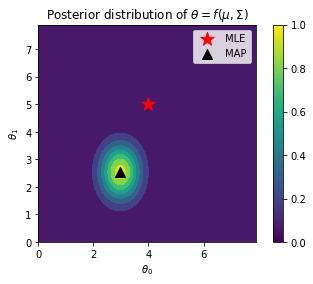

In [14]:
from scipy.stats import multivariate_normal
from matplotlib import cm
cov = np.array([[ 1 , 0], [0,  1]])
var_pos = multivariate_normal(mean=MN, cov=SN)
x_grid, y_grid = np.mgrid[0:8:.1, 0:8:.1]
pos = np.dstack((x_grid, y_grid))
z = var_pos.pdf(pos)
plt.contourf(x_grid, y_grid, z)
plt.gca().set_aspect('equal')
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.title(r"Posterior distribution of $\theta = f(\mu, \Sigma)$")
plt.scatter(4, 5, s=200, marker='*', color='r', label='MLE')
plt.scatter(MN[0], MN[1], s=100, marker='^', color='black', label='MAP')

plt.colorbar()
plt.legend()
plt.savefig("../images/blr-map.png")

Sample from posterior

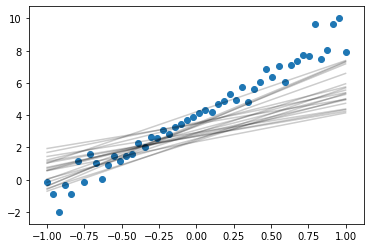

In [15]:
n_samples = 20
for n in range(n_samples):
    theta_0_s, theta_1_s = var_pos.rvs()
    plt.plot(x, theta_1_s*x + theta_0_s, color='k',alpha=0.2)
plt.scatter(x, y)



### Posterior predictions

$$
\begin{aligned}
p\left(y_{*} | \mathcal{X}, \mathcal{Y}, \boldsymbol{x}_{*}\right) &=\int p\left(y_{*} | \boldsymbol{x}_{*}, \boldsymbol{\theta}\right) p(\boldsymbol{\theta} | \mathcal{X}, \mathcal{Y}) \mathrm{d} \boldsymbol{\theta} \\
&=\int \mathcal{N}\left(y_{*} | \boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right) \boldsymbol{\theta}, \sigma^{2}\right) \mathcal{N}\left(\boldsymbol{\theta} | \boldsymbol{m}_{N}, \boldsymbol{S}_{N}\right) \mathrm{d} \boldsymbol{\theta} \\
&=\mathcal{N}\left(y_{*} | \boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right) \boldsymbol{m}_{N}, \boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right) \boldsymbol{S}_{N} \boldsymbol{\phi}\left(\boldsymbol{x}_{*}\right)+\sigma^{2}\right)
\end{aligned}
$$

For a point $x*$

Predictive mean = $X^Tm_N$

Predictive variance = $X^TS_NX + \sigma^2$

In [16]:
x_plus_1.T.shape, SN.shape, x_plus_1.shape

((2, 50), (2, 2), (50, 2))

In [17]:
pred_var = x_plus_1@SN@x_plus_1.T
pred_var.shape

(50, 50)

In [18]:
## Marginal
individual_var = pred_var.diagonal()

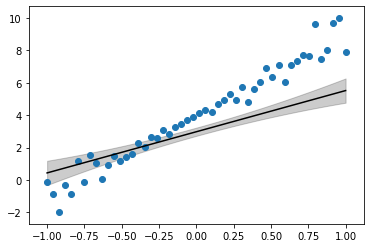

In [19]:
y_hat_map = x_plus_1@MN

plt.plot(x, y_hat_map, color='black')
plt.fill_between(x.flatten(), y_hat_map-individual_var, y_hat_map+individual_var, alpha=0.2, color='black')
plt.scatter(x, y)